# Quora Questions Classification Based on Word Vectors
## using Spacy with vectors only statistical model en_vectors_web_lg
## and clean text data (no punctuations, no stop words)


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORKING_DIR = os.path.join('.input', 'spacy_vectors_clean_data')

In [3]:
quora = pd.read_csv('../data/.input/train.csv')

In [4]:
quora.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [5]:
quora_train, quora_test = train_test_split(quora, random_state=42)
quora_train_data = quora_train.question_text
quora_train_labels = quora_train.target * 2.0 - 1.0
quora_test_data = quora_test.question_text
quora_test_labels = quora_test.target * 2.0 - 1.0

In [7]:
%%time

import spacy
nlp = spacy.load('en_vectors_web_lg')

Wall time: 15.7 s


In [8]:
def clean_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
    return ' '.join(lemmas)

def vectorize_text(text):
    return nlp(clean_text(text)).vector

def to_vw_format(document, label=None):
    vector = vectorize_text(document)
    values = []
    for index, value in enumerate(vector):
        values.append('f{}:{}'.format(index, value))
    return str(label or '') + ' |n ' + ' '.join(values) + '\n'

to_vw_format(quora_train_data.iloc[0], quora_train_labels[0])[:70]

'-1.0 |n f0:0.017512090504169464 f1:0.06360262632369995 f2:-0.058652877'

In [9]:
!!mkdir $WORKING_DIR
trainDataPath = os.path.join(WORKING_DIR, 'train.vw')
testDataPath = os.path.join(WORKING_DIR, 'test.vw')

In [10]:
%%time

with open(trainDataPath, 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(quora_train_data, quora_train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(testDataPath, 'w', encoding='utf-8') as vw_test_data:
    for text, target in zip(quora_test_data, quora_test_labels):
        vw_test_data.write(to_vw_format(text, target))

Wall time: 29min 44s


## Logistic loss function

In [34]:
logisticModelPath = os.path.join(WORKING_DIR, 'logistic_model.vw')
logisticPredictionsPath = os.path.join(WORKING_DIR, 'logistic_test_predictions.txt')
logisticCachePath = os.path.join(WORKING_DIR, 'logistic_cache')

In [17]:
!!vw -d $trainDataPath --cache_file $logisticCachePath --loss_function logistic -f $logisticModelPath

['final_regressor = .input\\logistic_spacy_vectors_clean_data\\logistic_model.vw',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'creating cache_file = .input\\logistic_spacy_vectors_clean_data\\logistic_cache',
 'Reading datafile = .input\\logistic_spacy_vectors_clean_data\\train.vw',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '0.693147 0.693147            1            1.0  -1.0000   0.0000      301',
 '3.672194 6.651240            2            2.0  -1.0000   6.6499      301',
 '2.202084 0.731974            4            4.0  -1.0000  -1.2130      301',
 '1.320490 0.438896            8            8.0  -1.0000  -0.7074      301',
 '1.049698 0.778906           16           16.0  -1.0000  -2.0616      301',
 '0.671467 0.293236           32           32.0  -1.0000  -0.5714      301',
 '0.469672 0.267876           64     

In [18]:
!!vw -i $logisticModelPath -t -d $testDataPath -p $logisticPredictionsPath --link logistic

['only testing',
 'predictions = .input\\logistic_spacy_vectors_clean_data\\logistic_test_predictions.txt',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using no cache',
 'Reading datafile = .input\\logistic_spacy_vectors_clean_data\\test.vw',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '26.973206 26.973206            1            1.0  -1.0000   0.0020      301',
 '19.841166 12.709126            2            2.0  -1.0000   0.0103      301',
 '17.599752 15.358338            4            4.0  -1.0000   0.0065      301',
 '18.258560 18.917368            8            8.0  -1.0000   0.0023      301',
 '13.514430 8.770299           16           16.0  -1.0000   0.0046      301',
 '14.027745 14.541060           32           32.0  -1.0000   0.0070      301',
 '12.413195 10.798646           64           64.0  -1.0000   0.0019

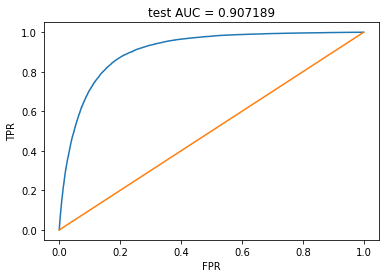

In [28]:
with open(logisticPredictionsPath) as pred_file:
    quora_test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(quora_test_labels, quora_test_prediction)
curve = roc_curve(quora_test_labels, quora_test_prediction)


plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);


In [29]:
quora_test_pred = list(map(lambda x: -1.0 if x < 0.5 else 1.0, quora_test_prediction))
print('accuracy', accuracy_score(quora_test_labels, quora_test_pred))
print('precision', precision_score(quora_test_labels, quora_test_pred))
print('recall', recall_score(quora_test_labels, quora_test_pred))
print('f1', f1_score(quora_test_labels, quora_test_pred))
confusion_matrix(quora_test_labels, quora_test_pred)

accuracy 0.939965883790513
precision 0.5232751454696591
recall 0.18942775465168765
f1 0.2781603269875171


array([[303151,   3441],
       [ 16162,   3777]], dtype=int64)

## Squared loss function


In [21]:
squaredModelPath = os.path.join(WORKING_DIR, 'squared_model.vw')
squaredPredictionsPath = os.path.join(WORKING_DIR, 'squared_test_predictions.txt')
squaredCachePath = os.path.join(WORKING_DIR, 'squared_cache')

In [22]:
!!vw -d $trainDataPath --cache_file $squaredCachePath --loss_function squared -f $squaredModelPath

['final_regressor = .input\\logistic_spacy_vectors_clean_data\\squared_model.vw',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'creating cache_file = .input\\logistic_spacy_vectors_clean_data\\squared_cache',
 'Reading datafile = .input\\logistic_spacy_vectors_clean_data\\train.vw',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '1.000000 1.000000            1            1.0  -1.0000   0.0000      301',
 '1.000000 1.000000            2            2.0  -1.0000   0.0000      301',
 '0.907631 0.815263            4            4.0  -1.0000  -0.2059      301',
 '0.704349 0.501066            8            8.0  -1.0000  -0.4487      301',
 '0.795013 0.885677           16           16.0  -1.0000  -1.0000      301',
 '0.488533 0.182053           32           32.0  -1.0000  -0.4325      301',
 '0.373911 0.259290           64       

In [23]:
!!vw -i $squaredModelPath -t -d $testDataPath -p $squaredPredictionsPath

['only testing',
 'predictions = .input\\logistic_spacy_vectors_clean_data\\squared_test_predictions.txt',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using no cache',
 'Reading datafile = .input\\logistic_spacy_vectors_clean_data\\test.vw',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '0.000000 0.000000            1            1.0  -1.0000  -1.0000      301',
 '0.000000 0.000000            2            2.0  -1.0000  -1.0000      301',
 '0.000000 0.000000            4            4.0  -1.0000  -1.0000      301',
 '0.000000 0.000000            8            8.0  -1.0000  -1.0000      301',
 '0.014695 0.029390           16           16.0  -1.0000  -1.0000      301',
 '0.027472 0.040250           32           32.0  -1.0000  -1.0000      301',
 '0.039001 0.050529           64           64.0  -1.0000  -1.0000      301',
 '

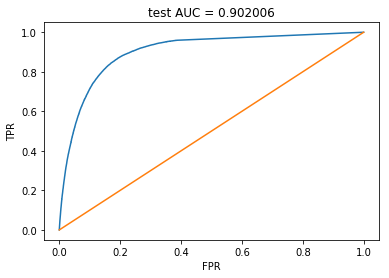

In [24]:
with open(squaredPredictionsPath) as pred_file:
    quora_test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(quora_test_labels, quora_test_prediction)
curve = roc_curve(quora_test_labels, quora_test_prediction)


plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

In [25]:
quora_test_pred = list(map(lambda x: -1.0 if x < 0.0 else 1.0, quora_test_prediction))
print('accuracy', accuracy_score(quora_test_labels, quora_test_pred))
print('precision', precision_score(quora_test_labels, quora_test_pred))
print('recall', recall_score(quora_test_labels, quora_test_pred))
print('f1', f1_score(quora_test_labels, quora_test_pred))
confusion_matrix(quora_test_labels, quora_test_pred)

accuracy 0.9405875705522599
precision 0.5586507072905332
recall 0.12874266512864235
f1 0.20926061791799133


array([[304564,   2028],
       [ 17372,   2567]], dtype=int64)

## Hinge loss function

In [27]:
hingeModelPath = os.path.join(WORKING_DIR, 'hinge_model.vw')
hingePredictionsPath = os.path.join(WORKING_DIR, 'hinge_test_predictions.txt')
hingeCachePath = os.path.join(WORKING_DIR, 'hinge_cache')

In [35]:
!!vw -d $trainDataPath --cache_file $hingeCachePath --loss_function hinge --l1 0.0000001 -f $hingeModelPath

['using l1 regularization = 1e-07',
 'final_regressor = .input\\logistic_spacy_vectors_clean_data\\hinge_model.vw',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using cache_file = .input\\logistic_spacy_vectors_clean_data\\hinge_cache',
 'ignoring text input in favor of cache input',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '1.000000 1.000000            1            1.0  -1.0000   0.0000      301',
 '1.000000 1.000000            2            2.0  -1.0000   0.0000      301',
 '0.948477 0.896954            4            4.0  -1.0000  -0.2061      301',
 '0.808429 0.668381            8            8.0  -1.0000  -0.4850      301',
 '0.746306 0.684182           16           16.0  -1.0000  -1.0000      301',
 '0.506721 0.267136           32           32.0  -1.0000  -0.4783      301',
 '0.381359 0.255998           64     

In [36]:
!!vw -i $hingeModelPath -t -d $testDataPath -p $hingePredictionsPath

['only testing',
 'predictions = .input\\logistic_spacy_vectors_clean_data\\hinge_test_predictions.txt',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using no cache',
 'Reading datafile = .input\\logistic_spacy_vectors_clean_data\\test.vw',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '0.000000 0.000000            1            1.0  -1.0000  -1.0000      301',
 '0.000000 0.000000            2            2.0  -1.0000  -1.0000      301',
 '0.000000 0.000000            4            4.0  -1.0000  -1.0000      301',
 '0.000000 0.000000            8            8.0  -1.0000  -1.0000      301',
 '0.000000 0.000001           16           16.0  -1.0000  -1.0000      301',
 '0.000020 0.000040           32           32.0  -1.0000  -1.0000      301',
 '0.058748 0.117475           64           64.0  -1.0000  -1.0000      301',
 '0.

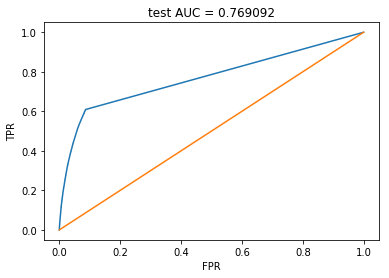

In [37]:
with open(hingePredictionsPath) as pred_file:
    quora_test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(quora_test_labels, quora_test_prediction)
curve = roc_curve(quora_test_labels, quora_test_prediction)


plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

In [39]:
quora_test_pred = list(map(lambda x: -1.0 if x < 0.0 else 1.0, quora_test_prediction))
print('accuracy', accuracy_score(quora_test_labels, quora_test_pred))
#print('precision', precision_score(quora_test_labels, quora_test_pred))
#print('recall', recall_score(quora_test_labels, quora_test_pred))
#print('f1', f1_score(quora_test_labels, quora_test_pred))
confusion_matrix(quora_test_labels, quora_test_pred)

accuracy 0.9389368850124491


array([[306592,      0],
       [ 19939,      0]], dtype=int64)